# GP hyperparameters

**Goal:** We wanted to check to see how the GP fit depended on :

1. \# of bins (a.k.a, the discretization level)
2. The range of the fit used
3. Adding a non-zero prior into the fit

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/','../PAG-opt/'] 

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import boost_histogram as bh
import hist

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *

%load_ext autoreload
%autoreload 2

**For starters, let's look at the rev $\Delta \eta_{HH}$ fits**

In [2]:
# python bkgPred.py -d ../data/RR/cryptotuples/rev_deta/data_rev_deta_16.root --ntag 4 --detaCut 1 --nbinsx 50 --nbinsy 50 --nEvents 100000 --gp_only --subDir data161718-MAY21_4b_rev_deta_ggf/ --tag _nsamp_1m_16 --flow_config configs/val1p1.json

**Step 1:** Dependence on massplane discretization

In [3]:
nbins_list = [15,20,25,30,40,50,60,70] 

In [4]:
obs_16 = 4424
obs_17 = 5595
obs_18 = 10421

obs_all = obs_16+obs_17+obs_18

In [5]:
sr_16 = np.array([4601.65, 4558.42, 4552.10, 4624.56,
                  4592.97, 4605.11])
sr_17 = np.array([5652.7,5677.62,5552.08,5611.87, 
                  5646.57,5672.87,5257.43])
sr_18 = np.array([10123.94,10317.32,10372.15, 10317.20,
                  10298.25,10503.46,10423.29,10378.53])

In [6]:
nSuc = min(len(sr_16),len(sr_17),len(sr_18))
sr_all_parts = sr_16[:nSuc]+sr_17[:nSuc]+sr_18[:nSuc]

In [7]:
sr_all_parts

array([20378.29, 20553.36, 20476.33, 20553.63, 20537.79, 20781.44])

In [10]:
subDir = 'data161718-MAY21_4b_rev_deta_ggf'
modelDir = f'../gp-for-flows/models/{subDir}'

region_tag = "\n4b, rev $\Delta \eta_{HH}$ SR"
figDir = 'data161718-MAY21_4b_rev_deta_ggf'

In [11]:
sr_all = [20432.030970487194,21481.758155210355,20399.57512208575,
          20358.38046832307, 20528.216897482085, 19850.8912715942]

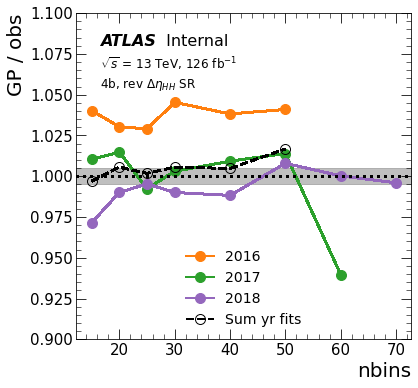

In [51]:
ms = 10
lw=2

plt.figure(figsize = (6,6))

plt.plot(nbins_list[:len(sr_16)],sr_16/obs_16,color='C1',label='2016',
         marker='o',markersize=ms,lw=lw)
plt.plot(nbins_list[:len(sr_17)],sr_17/obs_17,'C2',label='2017',
         marker='o',markersize=ms,lw=lw)
plt.plot(nbins_list[:len(sr_18)],sr_18/obs_18,'C4',label='2018',
         marker='o',markersize=ms,lw=lw)

plt.plot(nbins_list[:len(sr_all_parts)],sr_all_parts/obs_all,label='Sum yr fits',
         marker='o',markersize=ms,fillstyle='none',color='k',ls='--',lw=2)

plt.xlabel('nbins',loc='right',fontsize=20)
plt.ylabel('GP / obs',loc='top',fontsize=20)

plt.legend(loc='lower center')

xlim = plt.xlim()

plt.fill_between(xlim,1.005,.995,color='grey',alpha=.5)

plt.plot(xlim,[1]*2,'k',ls='dotted')
plt.xlim(xlim)

second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi('all'))+" fb$^{-1}$"+region_tag

fig,ax = plt.gcf(), plt.gca()
pas.makeATLAStag(ax, fig, first_tag=' Internal', second_tag=second_tag,
                 ymax=.89,xmin=.07,line_spacing=.9,
                 fontsize_title=16,fontsize_label=12)    

plt.ylim(.9,1.1)

plt.savefig(f'figures/{subDir}/GP-over-obs-nbins.pdf',bbox_inches='tight')

plt.show()

**Q:** Does the dependence on the # of bins vary at all based of how large the # of events is??

In [28]:
def getNorm(pipe,nsamp=20000):
    
    m1m2 = np.random.uniform(low=low_bounds, high=high_bounds, size=(nsamp, 2))
    pred_all = pipe.predict(m1m2) * std + mu

    pred_out = np.sum(pred_all[Xhh(*m1m2.T, x, y) > 1.6]) 
    pred_sig = np.sum(pred_all[Xhh(*m1m2.T, x, y) < 1.6]) 

    n_sig = pred_sig / pred_out * dat_out

    return n_sig

In [29]:
yrs = [16,17,18]

In [30]:
x,y = 124,117

x_cr, y_cr = (x*1.05, y*1.05)
r_cr = 45

xmin = x_cr-r_cr
xmax = x_cr+r_cr

ymin = y_cr-r_cr
ymax = y_cr+r_cr

In [31]:
low_bounds  = [xmin, ymin]
high_bounds = [xmax, ymax]

In [32]:
dfs = []
dat_out = 0
load_cols = ['m_h1', 'm_h2','ntag','pass_vbf_sel','X_hh']

for yr in yrs:
    fname = f'../data/RR/cryptotuples/rev_deta/data_rev_deta_{yr}.root'

    print(fname)
    with uproot.open(fname) as f:

        dfi = f['fullmassplane'].arrays(load_cols,library='pd')
        
    m_4b = (~dfi.pass_vbf_sel) &(dfi.ntag >= 4)
    dat_out_i = np.sum(dfi.loc[m_4b & (dfi.m_h1 > xmin) & (dfi.m_h1 < xmax) & \
                         (dfi.m_h2 > ymin) & (dfi.m_h2 < ymax) ,'X_hh']>1.6)

    dat_out += dat_out_i
    
    dfs.append(dfi)

../data/RR/cryptotuples/rev_deta/data_rev_deta_16.root
../data/RR/cryptotuples/rev_deta/data_rev_deta_17.root
../data/RR/cryptotuples/rev_deta/data_rev_deta_18.root


In [91]:
cols = pd.MultiIndex.from_product([yrs, ['lx','ly','LL','n_sig','obs / n_sig']])
fit_metrics = pd.DataFrame(0,nbins_list,cols)

for nbins, yr in product(nbins_list,yrs):
    
    fname = f'../gp-for-flows/models/{subDir}/GPfit_nbins_{nbins}_{yr}.npz'
    
    gp_file = np.load(fname)
    
    fit_metrics.loc[nbins,(yr,'lx')] = gp_file['fitted_len'][0]
    fit_metrics.loc[nbins,(yr,'ly')] = gp_file['fitted_len'][1]
    fit_metrics.loc[nbins,(yr,'LL')] = gp_file['LL']
    fit_metrics.loc[nbins,(yr,'n_sig')] = gp_file['n_sig']

In [102]:
for yr, obs in zip(yrs, [obs_16, obs_17,obs_18]):
    
    fit_metrics[(yr,'obs / n_sig')] = fit_metrics[(yr,'n_sig')] / obs

In [116]:
x=124 
y=117
res_x=0.1 
res_y=0.1
Xhh=1.6

# res = 0.1 # assuming 10% resolution

SR_x = np.linspace(x / (1 + res_x * Xhh) + 1e-7, x / (1 - res_x * Xhh))
alpha = np.power((SR_x - x) / (res_x * SR_x), 2)
SR_y1 = y / (1 + res_y * np.sqrt(np.power(Xhh, 2) - alpha))
SR_y2 = y / (1 - res_y * np.sqrt(np.power(Xhh, 2) - alpha))

xx = np.hstack([SR_x, SR_x[::-1]])
yy = np.hstack([SR_y1, SR_y2[::-1]])

yy = np.nan_to_num(yy, nan=y)


In [118]:
max(xx)-min(xx)

40.722495794909705

In [119]:
max(yy)-min(yy)

38.41742105658692

In [100]:
fit_metrics[(yr,'obs / n_sig')] = fit_metrics[(yr,'n_sig')] / obs

In [103]:
fit_metrics

16                                              17             \
           lx         ly           LL        n_sig         lx         ly   
15  57.630970  61.923090   -61.188605  4601.656183  63.424665  64.305354   
20  59.027787  62.051171  -149.627773  4558.422518  61.532789  67.141309   
25  59.758764  64.868288  -297.846682  4552.101993  63.620225  68.506422   
30  58.665298  66.582217  -503.319849  4624.562755  64.311682  70.675256   
40  59.702826  69.785843 -1118.063449  4592.967464  63.774587  75.393175   
50  61.859821  72.159899 -1977.531253  4605.117404  65.752877  77.219423   
60  17.700000  17.700000 -3950.742937  7728.092229  17.700000  17.700000   
70  17.742857  17.742857 -6875.963593  5190.171693  17.742857  17.742857   

                                     18                                        \
             LL        n_sig         lx         ly           LL         n_sig   
15   -55.798233  5652.778296  60.276405  63.933693   -24.094656  10123.944843   
20  -144.244237  5677.625878  59.098898  66.122050   -85.798069  10317.316822   
25  -285.284140  5552.083528  60.678048  68.567533  -191.561434  10372.151626   
30  -484.001608  5611.871540  59.985569  69.401443  -342.777004  10317.202979   
40 -1077.226955  5646.577732  59.967542  71.705405  -835.268995  10298.247424   
50 -1941.774226  5672.873171  59.994511  75.124873 -1552.506890  10503.460330   
60 -3459.051048  5257.432002  59.931958  76.861116 -2558.925931  10524.979603   
70 -6210.690831  2396.196548  60.493956  79.475256 -3819.532257  10378.536072   

         16                                  17          18  
   (lx, ly) obs / n_sig obs / n_sig obs / n_sig obs / n_sig  
15      NaN    1.040157    1.040157    1.010327    0.971495  
20      NaN    1.030385    1.030385    1.014768    0.990051  
25      NaN    1.028956    1.028956    0.992329    0.995313  
30      NaN    1.045335    1.045335    1.003015    0.990040  
40      NaN    1.038193    1.038193    1.009219    0.988221  
50      NaN    1.040940    1.040940    1.013918    1.007913  
60      NaN    1.746856    1.746856    0.939666    1.009978  
70      NaN    1.173185    1.173185    0.428275    0.995925

In [105]:
fit_metrics.loc[:,(yrs,['lx','ly'])]

16                    17                    18           
           lx         ly         lx         ly         lx         ly
15  57.630970  61.923090  63.424665  64.305354  60.276405  63.933693
20  59.027787  62.051171  61.532789  67.141309  59.098898  66.122050
25  59.758764  64.868288  63.620225  68.506422  60.678048  68.567533
30  58.665298  66.582217  64.311682  70.675256  59.985569  69.401443
40  59.702826  69.785843  63.774587  75.393175  59.967542  71.705405
50  61.859821  72.159899  65.752877  77.219423  59.994511  75.124873
60  17.700000  17.700000  17.700000  17.700000  59.931958  76.861116
70  17.742857  17.742857  17.742857  17.742857  60.493956  79.475256

In [104]:
fit_metrics.loc[:,(yrs,['LL','obs / n_sig'])]

16                       17                       18            
             LL obs / n_sig           LL obs / n_sig           LL obs / n_sig
15   -61.188605    1.040157   -55.798233    1.010327   -24.094656    0.971495
20  -149.627773    1.030385  -144.244237    1.014768   -85.798069    0.990051
25  -297.846682    1.028956  -285.284140    0.992329  -191.561434    0.995313
30  -503.319849    1.045335  -484.001608    1.003015  -342.777004    0.990040
40 -1118.063449    1.038193 -1077.226955    1.009219  -835.268995    0.988221
50 -1977.531253    1.040940 -1941.774226    1.013918 -1552.506890    1.007913
60 -3950.742937    1.746856 -3459.051048    0.939666 -2558.925931    1.009978
70 -6875.963593    1.173185 -6210.690831    0.428275 -3819.532257    0.995925

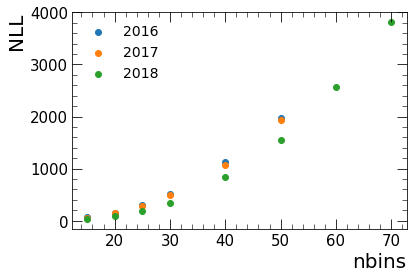

In [114]:
for yr, c, n in zip(yrs,['C1','C2','C4'],[6,6,8]):
    
    x = nbins_list[:n]
    y = -fit_metrics[(yr,'LL')][:n]
    plt.scatter(x,y,label=f'20{yr}')

plt.xlabel('nbins',loc='right',fontsize=20)
plt.ylabel('NLL',loc='top',fontsize=20)
plt.legend()

plt.show()

In [63]:
for k in gp_file.keys() :
    print(k)

m1m2
bkgd_2d
bkgd
stat_err
norm_bkgd
norm_stat_err
bkgdmodel
uncert
mean
std
n_sig
LL
fitted_len


In [122]:
pipe['scaler'](.1)

TypeError: 'MinMaxScaler' object is not callable

In [57]:
%%bash
ls ../gp-for-flows/models/data161718-MAY21_4b_rev_deta_ggf

df_gp_100k_16.h5
df_gp_100k_17.h5
df_gp_100k_18.h5
df_gp_100k_nbins_15_16.h5
df_gp_100k_nbins_15_17.h5
df_gp_100k_nbins_15_18.h5
df_gp_100k_nbins_20_16.h5
df_gp_100k_nbins_20_17.h5
df_gp_100k_nbins_20_18.h5
df_gp_100k_nbins_25_16.h5
df_gp_100k_nbins_25_17.h5
df_gp_100k_nbins_25_18.h5
df_gp_100k_nbins_30_16.h5
df_gp_100k_nbins_30_17.h5
df_gp_100k_nbins_30_18.h5
df_gp_100k_nbins_40_16.h5
df_gp_100k_nbins_40_17.h5
df_gp_100k_nbins_40_18.h5
df_gp_100k_nbins_50_16.h5
df_gp_100k_nbins_50_17.h5
df_gp_100k_nbins_50_18.h5
df_gp_100k_nbins_60_16.h5
df_gp_100k_nbins_60_17.h5
df_gp_100k_nbins_60_18.h5
df_gp_100k_nbins_70_16.h5
df_gp_100k_nbins_70_17.h5
df_gp_100k_nbins_70_18.h5
df_gp_100k_nsamp_1m_16.h5
df_gp_100knsamp_1m.h5
df_gp_100k_pipe_16.h5
df_gp_100k_pipe_17.h5
df_gp_100k_pipe_18.h5
GPfit_nbins_15_16.npz
GPfit_nbins_15_17.npz
GPfit_nbins_15_18.npz
GPfit_nbins_20_16.npz
GPfit_nbins_20_17.npz
GPfit_nbins_20_18.npz
GPfit_nbins_25_16.npz
GPfit_nbins_25_17.npz
GPfit_nbins_25_18.npz
GPfit_nbins_3

bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)


In [33]:
for nbins in nbins_list[:len(sr_18)]:
    
    # Reconstruct the center values of the massplane grid
    ex = np.linspace(x_cr-r_cr,x_cr+r_cr,nbins+1)
    ey = np.linspace(y_cr-r_cr,y_cr+r_cr,nbins+1)
    
    w_x = widths(ex)
    w_y = widths(ey)
    mids_x = mid(ex)
    mids_y = mid(ey)

    xx, yy = np.meshgrid(mids_x, mids_y)
    m1m2 = np.vstack([xx.flatten(), yy.flatten()]).T

    m1m2_ur = np.array(
        list(itertools.product(mids_x + w_x / 2.0, mids_y + w_y / 2.0))
    )
    m1m2_dr = np.array(
        list(itertools.product(mids_x + w_x / 2.0, mids_y - w_y / 2.0))
    )
    m1m2_ul = np.array(
        list(itertools.product(mids_x - w_x / 2.0, mids_y + w_y / 2.0))
    )
    m1m2_dl = np.array(
        list(itertools.product(mids_x - w_x / 2.0, mids_y - w_y / 2.0))
    )

    blind = (
          (Xhh(*m1m2_ur.T, x, y) > 1.6)
        & (Xhh(*m1m2_dr.T, x, y) > 1.6)
        & (Xhh(*m1m2_ul.T, x, y) > 1.6)
        & (Xhh(*m1m2_dl.T, x, y) > 1.6)
    )

    # Load in the gp fit files
    gp_files = [np.load(f'{modelDir}/GPfit_nbins_{nbins}_{yr}.npz') for yr in yrs]
    
    # Add them up
    bkgd_2d = np.sum(np.dstack([gf['bkgd_2d'] for gf in gp_files]),axis=-1)
    bkgd = bkgd_2d.flatten()
    
    # Normalize the # of events
    mu, std = np.mean(bkgd[blind]), np.std(bkgd[blind])

    norm_bkgd = (bkgd[blind] - mu)/std
    norm_stat_err = np.sqrt(bkgd[blind]) / std
    
    # Perform the fit
    kern = RBF(length_scale=[0.5, 0.5], length_scale_bounds=(0.2, 1.5))

    pipe = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            (
                "GP",
                GaussianProcessRegressor(
                    kern, n_restarts_optimizer=25, alpha=norm_stat_err
                ),
            ),
        ]
    )

    pipe.fit(m1m2[blind], norm_bkgd)
    print(pipe["GP"].kernel_.length_scale / pipe["scaler"].scale_)

    (bkgdmodel, uncert) = pipe.predict(m1m2, return_std=True)
    
    # Estimate the # of events 
    n_sig = getNorm(pipe)
    print('nbins=',nbins,':  n_sig=',n_sig)
    
    # Be happy
    
    #reak

[60.13630178 66.67328205]
nbins= 15 :  n_sig= 20150.167817305486
[59.36239696 68.23653068]
nbins= 20 :  n_sig= 19677.67551562446
[60.72637865 69.9767992 ]
nbins= 25 :  n_sig= 20757.392436743274
[60.36005635 71.34601662]
nbins= 30 :  n_sig= 19831.67356921418
[59.23306899 73.44073856]
nbins= 40 :  n_sig= 20715.142588889026
[59.56063892 75.4873264 ]
nbins= 50 :  n_sig= 20711.419624778177
[59.12561852 76.8135212 ]
nbins= 60 :  n_sig= 21155.072381661368
[59.06510866 79.26629664]
nbins= 70 :  n_sig= 21331.849142842326


In [123]:
print(np.array([.2,.2]) / pipe["scaler"].scale_)

[17.74285714 17.74285714]


In [124]:
90/25

3.6

In [125]:
120/3.6

33.333333333333336

In [126]:
150/3.6

41.666666666666664

In [38]:
n_all = np.array([20150.1678, 19677.6755, 20757.39244, 19831.6736, 
         20715.1426, 20711.4196, 21155.07238, 21331.8491])

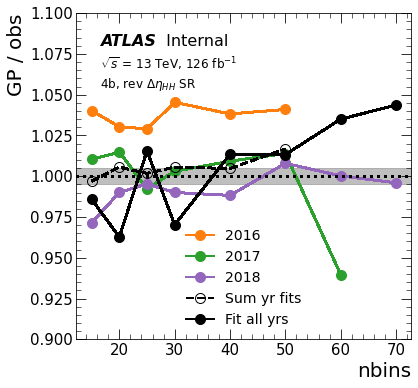

In [52]:
ms = 10
lw=2

plt.figure(figsize = (6,6))

plt.plot(nbins_list[:len(sr_16)],sr_16/obs_16,color='C1',label='2016',
         marker='o',markersize=ms,lw=lw)
plt.plot(nbins_list[:len(sr_17)],sr_17/obs_17,'C2',label='2017',
         marker='o',markersize=ms,lw=lw)
plt.plot(nbins_list[:len(sr_18)],sr_18/obs_18,'C4',label='2018',
         marker='o',markersize=ms,lw=lw)

plt.plot(nbins_list[:len(sr_all_parts)],sr_all_parts/obs_all,label='Sum yr fits',
         marker='o',markersize=ms,fillstyle='none',color='k',ls='--',lw=2)

plt.plot(nbins_list,n_all / obs_all,label='Fit all yrs',
         marker='o',markersize=ms,color='k',lw=2)


plt.xlabel('nbins',loc='right',fontsize=20)
plt.ylabel('GP / obs',loc='top',fontsize=20)

plt.legend(loc='lower center')

xlim = plt.xlim()

plt.fill_between(xlim,1.005,.995,color='grey',alpha=.5)

plt.plot(xlim,[1]*2,'k',ls='dotted')
plt.xlim(xlim)

second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(get_lumi('all'))+" fb$^{-1}$"+region_tag

fig,ax = plt.gcf(), plt.gca()
pas.makeATLAStag(ax, fig, first_tag=' Internal', second_tag=second_tag,
                 ymax=.89,xmin=.07,line_spacing=.9,
                 fontsize_title=16,fontsize_label=12)    

plt.ylim(.9,1.1)

plt.savefig(f'figures/{subDir}/GP-over-obs-nbins-fitAll.pdf',bbox_inches='tight')

plt.show()

**Would another kernel be better?**